## Introduction :
##### This is an analysis of Wikipedia comments to create models that identify various types of TOXIC comments. There is a lot of racist content and swear words in the dataset and some of it will pop-up in the analysis.

#### Dataset :
##### https://www.kaggle.com/datasets/julian3833/jigsaw-toxic-comment-classification-challenge/data

### Dataset Description :
###### The dataset consisted with a large number of Wikipedia comments which have been ladelled by human rates for toxic behaviour. The types of toxicity are:
##### 1. toxic
##### 2. severe_toxic
##### 3. obscene
##### 4. threat
##### 5. insult
##### 6.identfy_hate

#### - We must create a model which predicts a probability of each type of toxicity for each comment

In [1]:
# Required libraries:
import pandas as pd
import numpy as np
import nltk
import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Dataset :
df = pd.read_csv('/content/train.csv', engine='python', on_bad_lines='warn')
df_sub = pd.read_csv('/content/test.csv', engine='python', on_bad_lines='warn')

In [3]:
# Checking Null Values :
def check_null(df, columns):
  for col in columns:
    print(f"Column '{col}': {df[col].isnull().sum()} null values")
check_null(df, df.columns)

Column 'id': 0 null values
Column 'comment_text': 0 null values
Column 'toxic': 0 null values
Column 'severe_toxic': 0 null values
Column 'obscene': 0 null values
Column 'threat': 0 null values
Column 'insult': 0 null values
Column 'identity_hate': 0 null values


## Exploratory Data Analysis(EDA) :

In [4]:
# Features and Records :
print('%d Features and %d Records' % (df.shape[1], df.shape[0]))
print()

8 Features and 159571 Records



In [5]:
# Targeted Columns :
targeted_columns = list(df.columns[2:])
print("Targeted Columns :" + ','.join(targeted_columns))

Targeted Columns :toxic,severe_toxic,obscene,threat,insult,identity_hate


In [6]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [7]:
targets = list(df.columns[2:])
df_targets = df[targets].copy()
df_targets.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


toxic:
Total comments of this type: 15294
  severe_toxic: 1595
  obscene: 7926
  threat: 449
  insult: 7344
  identity_hate: 1302
  any_label: 15294

severe_toxic:
Total comments of this type: 1595
  toxic: 1595
  obscene: 1517
  threat: 112
  insult: 1371
  identity_hate: 313
  any_label: 1595

obscene:
Total comments of this type: 8449
  toxic: 7926
  severe_toxic: 1517
  threat: 301
  insult: 6155
  identity_hate: 1032
  any_label: 8449

threat:
Total comments of this type: 478
  toxic: 449
  severe_toxic: 112
  obscene: 301
  insult: 307
  identity_hate: 98
  any_label: 478

insult:
Total comments of this type: 7877
  toxic: 7344
  severe_toxic: 1371
  obscene: 6155
  threat: 307
  identity_hate: 1160
  any_label: 7877

identity_hate:
Total comments of this type: 1405
  toxic: 1302
  severe_toxic: 313
  obscene: 1032
  threat: 98
  insult: 1160
  any_label: 1405

any_label:
Total comments of this type: 16225
  toxic: 15294
  severe_toxic: 1595
  obscene: 8449
  threat: 478
  insult

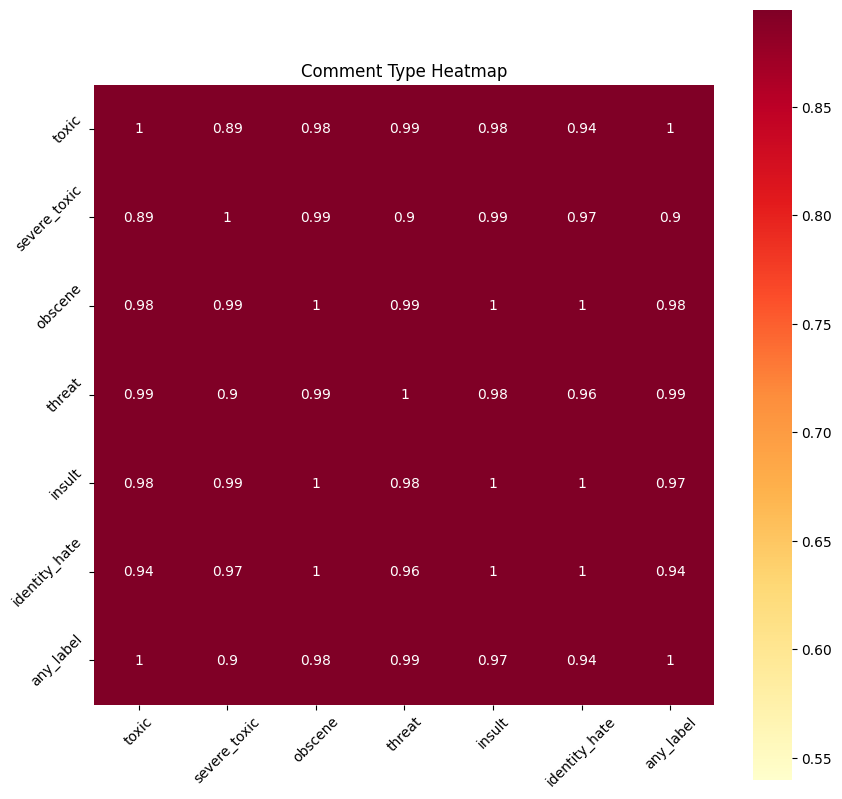



Training Data Comment Breakdown :
16225 out of 159571 comments, or 10.17%, are classified as toxic.
15294 toxic comments (9.58% of all data)
1595 severe_toxic comments (1.00% of all data)
8449 obscene comments (5.29% of all data)
478 threat comments (0.30% of all data)
7877 insult comments (4.94% of all data)
1405 identity_hate comments (0.88% of all data)
16225 any_label comments (10.17% of all data)


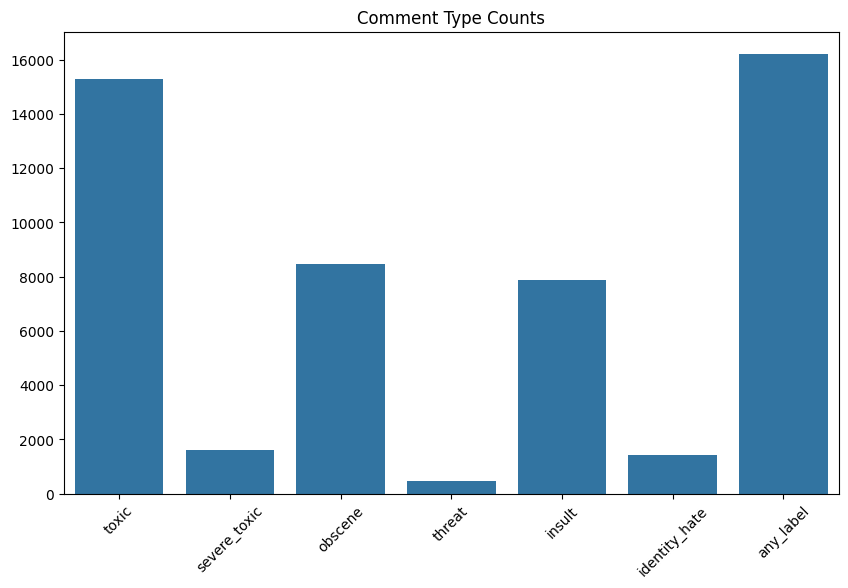

In [8]:
# Let's breakdown how many comments are toxic
# First, define the core toxic labels

toxic_labels = [
    'toxic',
    'severe_toxic',
    'obscene',
    'threat',
    'insult',
    'identity_hate'
]

# Create target dataframe
df_targets = df[toxic_labels].copy()

# any_label = at least one toxic label is True
toxic_rows = df_targets.sum(axis=1) > 0
df_targets['any_label'] = toxic_rows

targets = toxic_labels + ['any_label']

# Count co-occurrences
count_dic = {}

for comment_type in targets:
    counts_for_type = {}

    # Select rows where this label is True
    df_selection = df_targets[df_targets[comment_type] == True]

    # Total count
    counts_for_type['total'] = len(df_selection)

    # Co-occurrence with other labels
    others = [label for label in targets if label != comment_type]
    for other in others:
        counts_for_type[other] = df_selection[other].sum()

    count_dic[comment_type] = counts_for_type

    # Print breakdown
    print(f"{comment_type}:")
    print(f"Total comments of this type: {counts_for_type['total']}")
    for key, value in counts_for_type.items():
        if key != 'total':
            print(f"  {key}: {value}")
    print()

# Heatmap of correlations
def heatmap(df_data, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    df_corr = df_data.corr()
    sns.heatmap(
        df_corr,
        vmax=0.6,
        square=True,
        annot=True,
        cmap='YlOrRd'
    )
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()

heatmap(pd.DataFrame(count_dic), 'Comment Type Heatmap')
print('\n')

# Overall toxic statistics
print('Training Data Comment Breakdown :')

print('%d out of %d comments, or %.2f%%, are classified as toxic.' %
      (toxic_rows.sum(), len(df),
       (toxic_rows.sum() / len(df)) * 100))

# Bar plot of comment counts
labels = []
totals = []

for key, values in count_dic.items():
    labels.append(key)
    totals.append(values['total'])
    print('%d %s comments (%.2f%% of all data)' %
          (values['total'], key,
           (values['total'] / len(df)) * 100))

plt.figure(figsize=(10, 6))
plt.title('Comment Type Counts')
sns.barplot(x=labels, y=totals)
plt.xticks(rotation=45)
plt.show()

In [9]:
# Let's know how many comments need to be clean
for t in targets:
  print("Label : %s" %t)
  b = np.where(df_targets[t]==1)[0]
  selection = np.random.choice(b, 10)
  for s in selection:
    print(df.comment_text.loc[s])
  print("--------------------\n")
  print()

b = np.where(df_targets['any_label']==0)[0]
selection = np.random.choice(b, 10)
print("Clean Comments : ")
for s in selection:
  print(df.comment_text.loc[s])
  print()

Label : toxic
nasty ppl 

want to have Maggie May (dog) deleted they show no love.  (
YOU ARE ONE SAD LITTLE INDIVIDUAL.
you are deluded and i advise that you seek some mental help.
why bother signing with no intention of editing in the foreseeable future? why waste time doing that? would you like the contact details of the others involved? i feel sorry for you. i corrected 'favours' for you too. you are pathetic.
FUCK YOU Bluezy YOU ARE PROBABLY JUST A GAY WHO LIKES IT UP THE ASS!!!!!!!!!!!!!!!!!!!!!!!
Hey guys! This guy is a cunt nigger faggot.
WTF??? 

What the hell did i do???
dickhead 

dickhead im not vandalising, just changing necessary things, so go fuck yourself and see if i care if you block me. screw you fuckhead
YOU TOOK DOWN MY BORG INFO AND IT WAS PERFECT AND INFORMATIVE AND CORRECT AND TOLD A REAL STORY FLAW AND YOU RUINED IT U PICE OF SH..
Diem was a gay homosexual dictator 
This fact is indisputable
Nothing Gwen Gale says here is true.  She's a compulsive liar.  I am n

### Interesting Takeaways :
  - 'Toxic' represents over 90% of each other category.
  - Though all appear at first glance to be sub-categories of toxic, only 'severe_toxic' is 'toxic' 100% of the time.
  - Toxic isn't actually an overall category, some attribute of toxic ends up describing most insults, threats, hate comments, and obscenities.

  We don't have actual definitions of these classifications, so we can't know exactly what they mean and why, for ex: all 'identity_hate' comments aren't toxic. If it was higher, like 99%. I'd say labelling error, and just make 'toxic' an overall category that's true when any other category is true

## Feature Engineering :

In [10]:
df['length'] = df.comment_text.apply(lambda x: len(x))

print("Avg toxic comment length : %d" % int(np.mean(df[df_targets.any_label == 1]['length'])))
print("Avg clean comment length : %d" % int(np.mean(df[df_targets.any_label == 0]['length'])))

Avg toxic comment length : 303
Avg clean comment length : 404


In [11]:
print("Median toxic comment length : %d" % int(np.median(df[df_targets.any_label == 1]['length'])))
print("Median clean comment length : %d" % int(np.median(df[df_targets.any_label == 0]['length'])))

Median toxic comment length : 128
Median clean comment length : 216


In [12]:
def pct_caps(s):
  return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) +1)

df['caps'] = df.comment_text.apply(lambda x : pct_caps(x))

print("Percentage of Capitalized characters in clean comments : %d%%" % int(100*np.mean(df[(df_targets.any_label == 0)].caps)))
print("Percentage of Capitalized characters in toxic comments : %d%%" % int(100*np.mean(df[(df_targets.any_label == 1)].caps)))

Percentage of Capitalized characters in clean comments : 5%
Percentage of Capitalized characters in toxic comments : 14%


In [13]:
def word_length(s):
  s_split = s.split(' ')
  alphabetic_word_lengths = [len(w) for w in s_split if w.isalpha()]
  if not alphabetic_word_lengths:
    return 0  # Return 0 if there are no alphabetic words
  return np.mean(alphabetic_word_lengths)

df['word_length'] = df.comment_text.apply(lambda x : word_length(x))

print("Avg word length in clean comments : %.1f" % np.mean(df[(df_targets.any_label == 0)].word_length))
print("Avg word length in toxic comments : %.1f" % np.mean(df[(df_targets.any_label == 1)].word_length))

Avg word length in clean comments : 4.3
Avg word length in toxic comments : 4.1


In [14]:
df['exclamation'] = df.comment_text.apply(lambda s : len([c for c in s if c == '!']))

print("Exclamations in clean comments : %.1f" % np.mean(df[(df_targets.any_label == 0)].exclamation))
print("Exclamations in toxic comments : %.1f" % np.mean(df[(df_targets.any_label == 1)].exclamation))

Exclamations in clean comments : 0.3
Exclamations in toxic comments : 3.5


In [15]:
df['question'] = df.comment_text.apply(lambda s : len([c for c in s if c == '?']))

print("Question marks in clean comments : %.1f" % np.mean(df[(df_targets.any_label == 0)].question))
print("Question marks in toxic comments : %.1f" % np.mean(df[(df_targets.any_label == 1)].question))

Question marks in clean comments : 0.4
Question marks in toxic comments : 0.6


In [16]:
import re
ip = re.compile (r'(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
+ r'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')

def strip_ip(s, ip):
    try:
        found = ip.search(s)
        return s.replace(found.group(), ' ')
    except:
        return s

df.comment_text = df.comment_text.apply(lambda x : strip_ip(x, ip))

Label Overlap Summary
1 label : 39.2%
2 labels : 21.4%
3 labels : 25.9%
4 labels : 10.8%
5 labels : 2.4%
6 labels : 0.2%


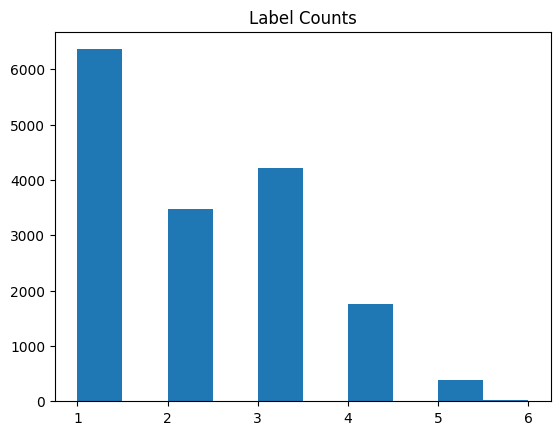

In [17]:
target_sums = np.sum(df_targets[df_targets.columns[:-1]], axis = 1)
target_sums = target_sums[(df_targets.any_label == 1)]
plt.figure('Label Counts')
plt.title('Label Counts')
plt.hist(target_sums)
print("Label Overlap Summary")

for i in range(1, 7):
  print('%d label%s : %.1f%%' % (i, 's' if i > 1 else '', 100 * len([s for s in target_sums if s == i]) / len(target_sums)))

### Split Labels from Training Data :

In [18]:
print("Training Labels :")
print(list(df_targets.columns))
print(df_targets.shape)
print()

print("Training Data :")
label_cols = df_targets.columns.difference(['any_label'])
X = df.drop(columns=list(label_cols) + ['id'], errors='ignore')
print(list(X.columns))
print(X.shape)

Training Labels :
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'any_label']
(159571, 7)

Training Data :
['comment_text', 'length', 'caps', 'word_length', 'exclamation', 'question']
(159571, 6)


## Natural Language Processing :

### Tokenized Sequences for Visualization :

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from nltk.corpus import stopwords
import string

top_words = 5000
tokenizer = Tokenizer(filters = string.punctuation + '\n', lower = True, num_words=top_words)
tokenizer.fit_on_texts(X.comment_text)

In [20]:
df['comment_sequence'] = tokenizer.texts_to_sequences(df.comment_text.str.lower())
df['comment_sequence']

,comment_sequence
0,"[678, 77, 1, 130, 133, 180, 31, 664, 4374, 109..."
1,"[166, 52, 2587, 13, 548, 3712, 3, 70, 4424, 26..."
2,"[409, 420, 3, 70, 137, 14, 252, 2, 76, 312, 10..."
3,"[60, 3, 37, 22, 99, 57, 327, 1422, 15, 2074, 3..."
4,"[6, 1662, 19, 31, 3378, 57, 1059, 6, 573, 42, ..."
...,...
159566,"[5, 12, 1, 424, 85, 4, 890, 83, 21, 313, 553, ..."
159567,"[6, 59, 16, 4504, 4, 211, 9, 8, 7, 3240, 235, ..."
159568,"[48, 727, 25, 12, 3422, 4306]"
159569,"[5, 10, 566, 53, 10, 26, 215, 6, 65, 205, 15, ..."


In [21]:
# Random Comment
str(df.comment_sequence[890])

'[1, 19, 641, 23, 1, 22, 856, 43, 19, 48, 2035, 2, 10, 13, 121, 126, 8, 201, 10, 412, 975, 1127, 17, 10, 10, 13, 8, 1, 1630, 856, 55, 95, 602, 39, 6, 125, 62, 2035, 981, 2379, 14, 969, 4, 3610, 17, 316, 17, 3, 72, 1, 531, 45, 1039, 2221, 641, 23, 62, 1907, 5, 4220, 319, 43, 8, 14, 97, 1, 1353, 4, 32, 842, 36, 42, 1813, 1493, 27, 13, 190, 18, 15, 1, 856, 24, 6, 95, 521, 43, 19, 2379, 39, 1, 2408, 4, 33, 1011, 2523, 2, 11, 2177, 319, 319]'

### Analyze Max Len, Choose appropriate 'max_len' :

In [22]:
max_len = df.comment_sequence.map(lambda x : len(x)).max()
print("Max Comment Length :",  max_len)

Max Comment Length : 1399


In [23]:
seq_lens = df.comment_sequence.map(lambda x : len(x))

for i in [10, 50, 100, 150, 200, 250, 300, 400, 500, 900, 1000, 1200]:
    select = (seq_lens > i)
    print('%.2f%% of Comments have more than %d words' % ((np.sum(select)/len(seq_lens))*100, i))

83.34% of Comments have more than 10 words
35.22% of Comments have more than 50 words
16.06% of Comments have more than 100 words
9.06% of Comments have more than 150 words
5.61% of Comments have more than 200 words
3.78% of Comments have more than 250 words
2.62% of Comments have more than 300 words
1.63% of Comments have more than 400 words
1.08% of Comments have more than 500 words
0.04% of Comments have more than 900 words
0.02% of Comments have more than 1000 words
0.01% of Comments have more than 1200 words


##### So, this data is going into an RNN and less data is always better. Because I'm going to be training on a CPU. I'm going to choose a cutoff 300 words for now.
##### My Logic ? I feel like an informative long-form comment isn't going to turn into a racist tirade highway. The first 300 words should be able to predict the sentiment of the enitre comment. I'll experiment more later, this is just a starting point.

### Visualize Word Counts :

In [24]:
def get_word_cnt(tokenzier):
    word_cnt = [(k,v) for k, v in zip(tokenzier.word_counts.keys(), # Changed 'tokenizer' to 'tokenzier' to match function argument
                                      tokenzier.word_counts.values())] # Changed 'tokenizer' to 'tokenzier'
    word_cnt.sort(key = lambda tup : tup[1], reverse = True)
    stop_words_set = set(stopwords.words('english')) # Renamed local variable to avoid conflict
    word_cnt = [tup for tup in word_cnt if tup[0] not in stop_words_set]
    return word_cnt

In [25]:
def word_plot(word_cnt, num_words, titles):
    plt.figure(titles, figsize = (18, 6))
    plt.suptitle(titles, fontsize = 40)
    sns.barplot(x = [tup[0] for tup in word_cnt[0:num_words]],
                y = [tup[1] for tup in word_cnt[0:num_words]])
    plt.xticks(fontsize = 20, rotation = 45, ha = 'right')
    plt.yticks(fontsize = 20)
    plt.show()

In [26]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

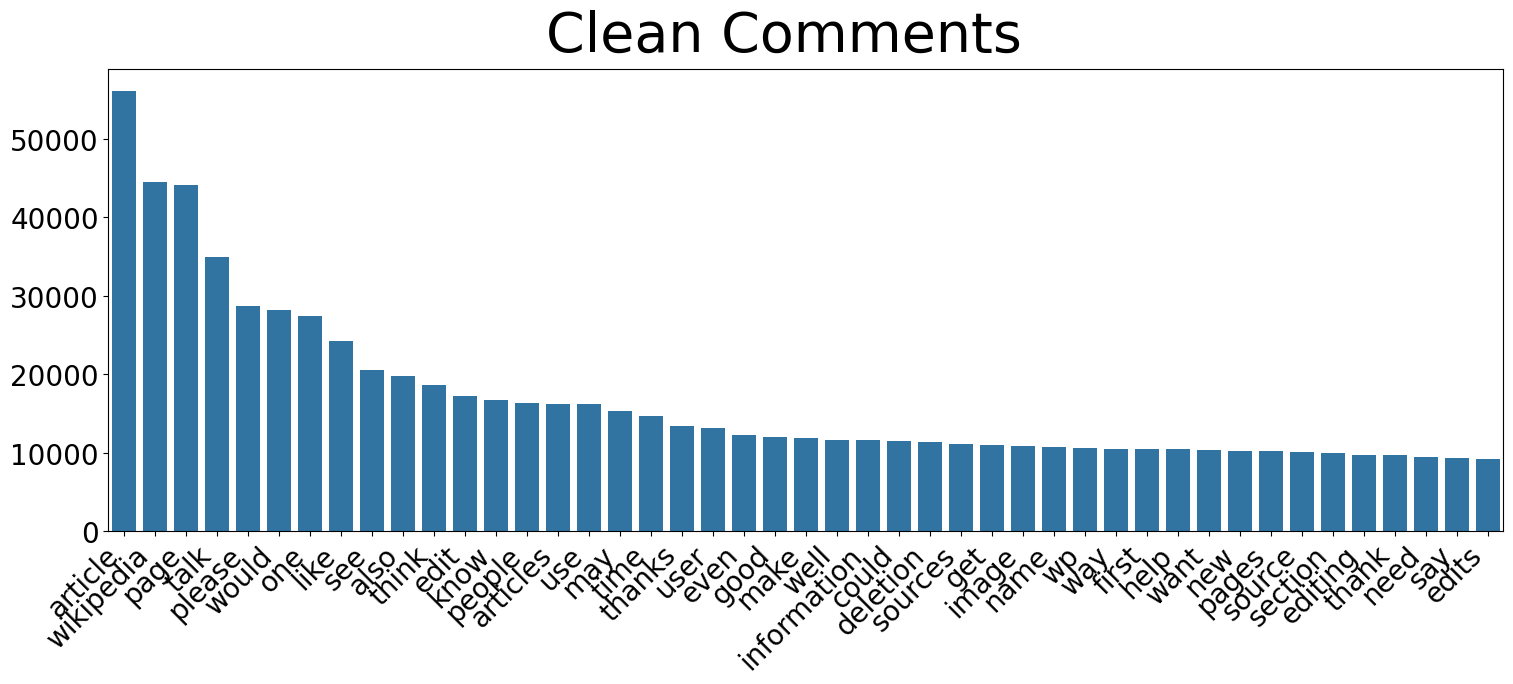

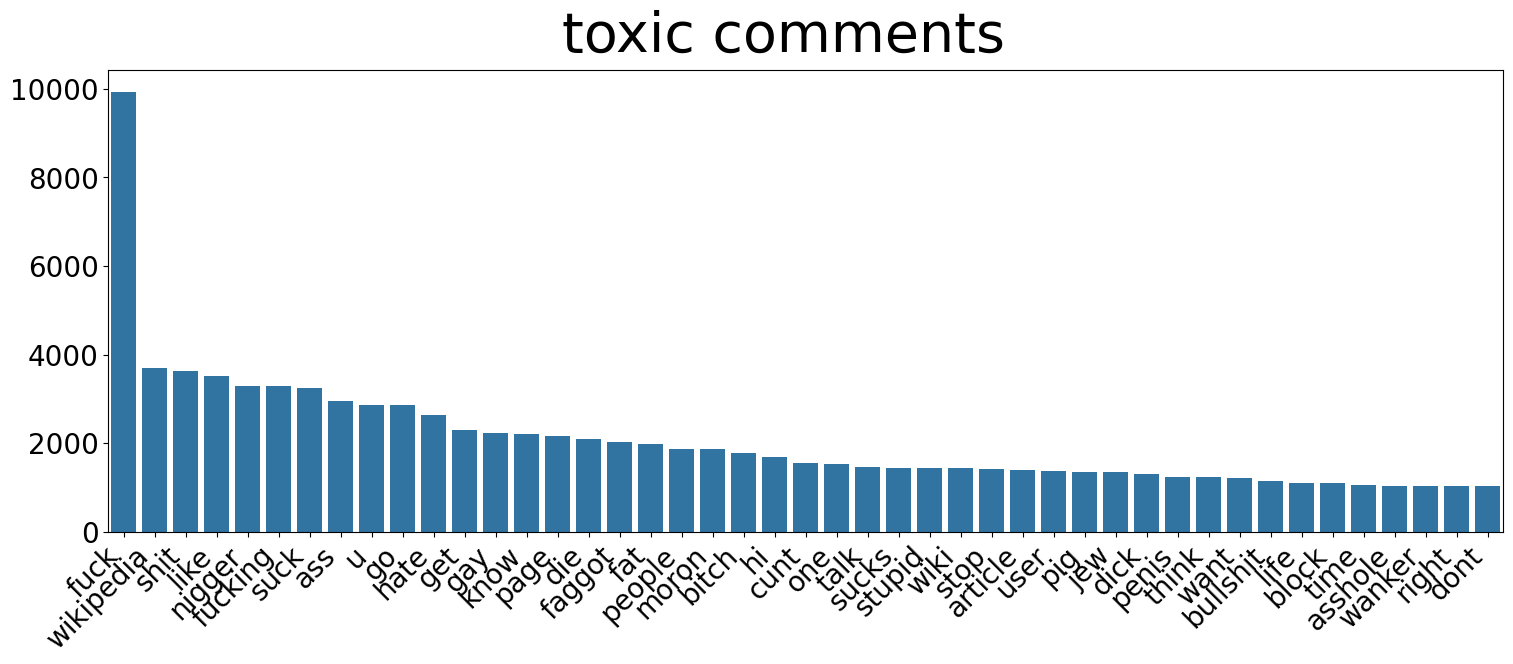

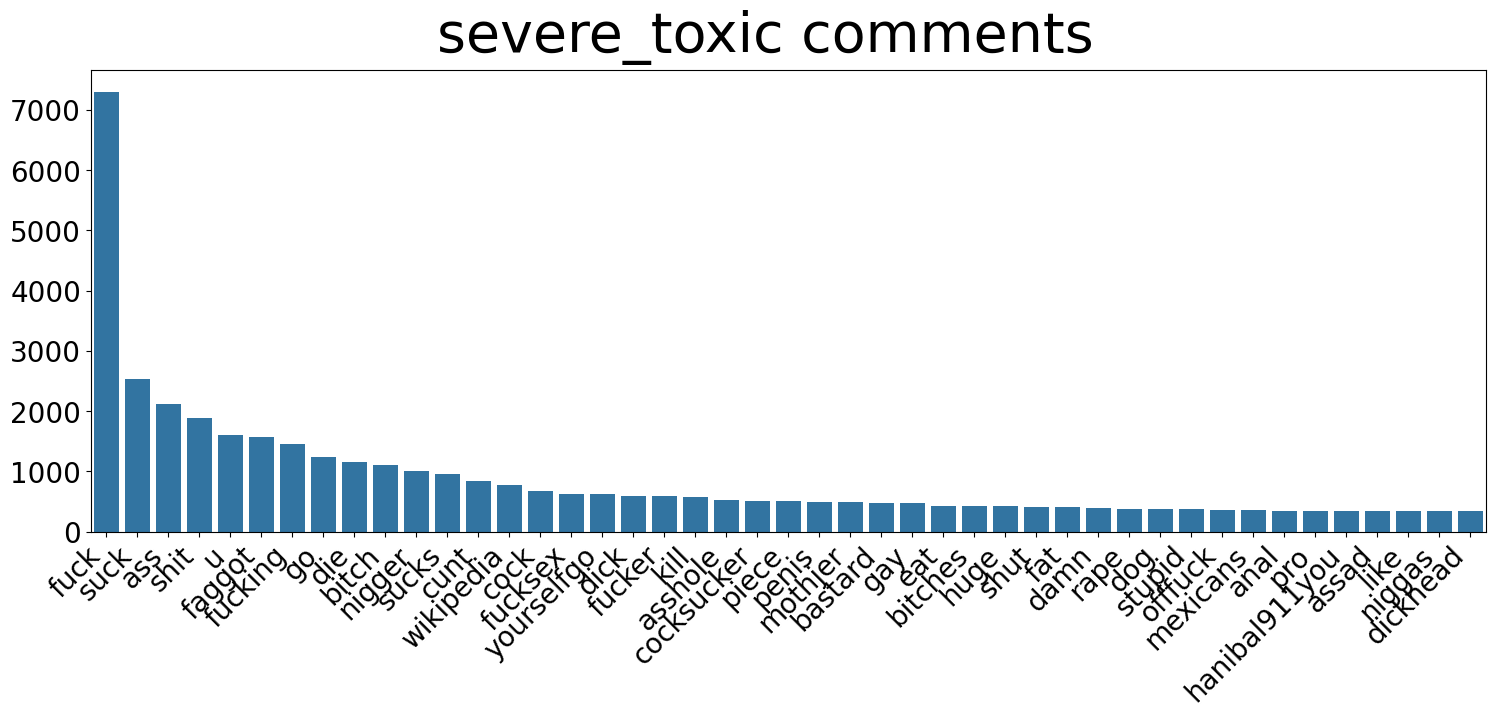

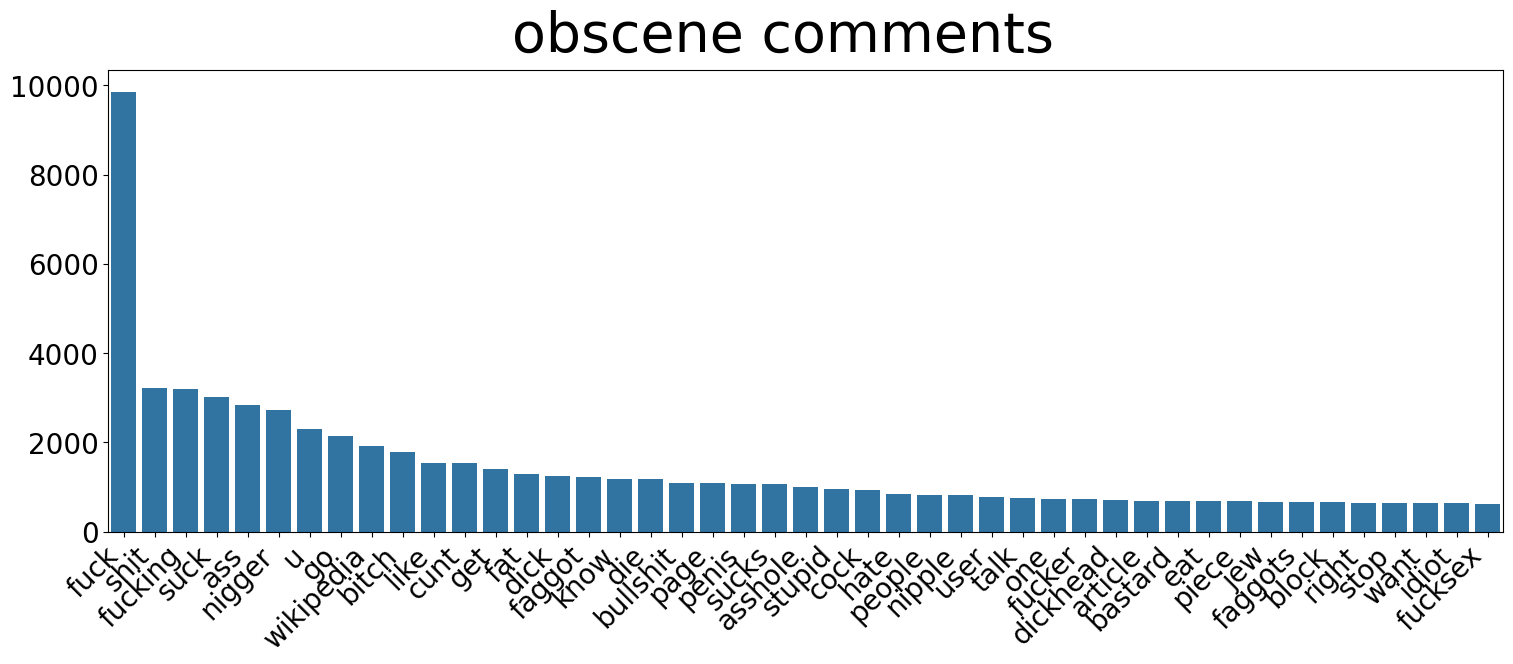

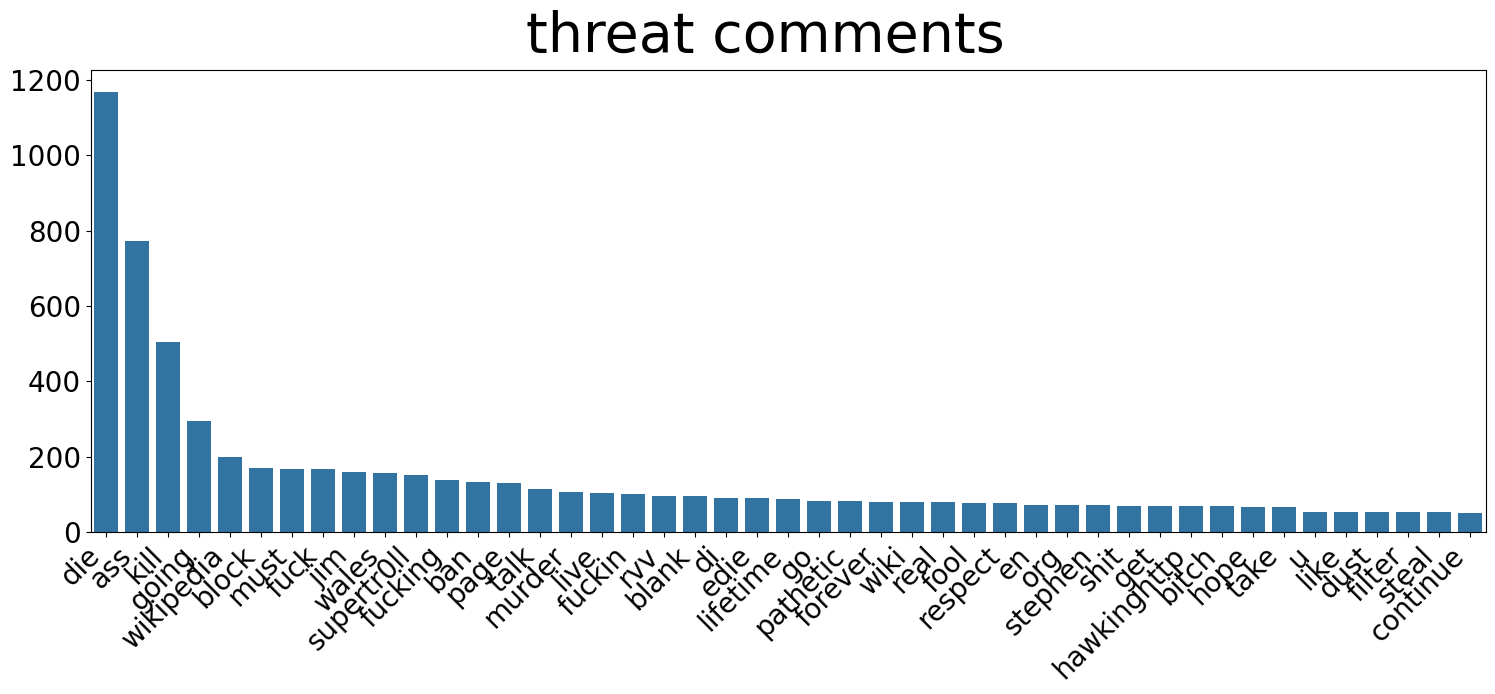

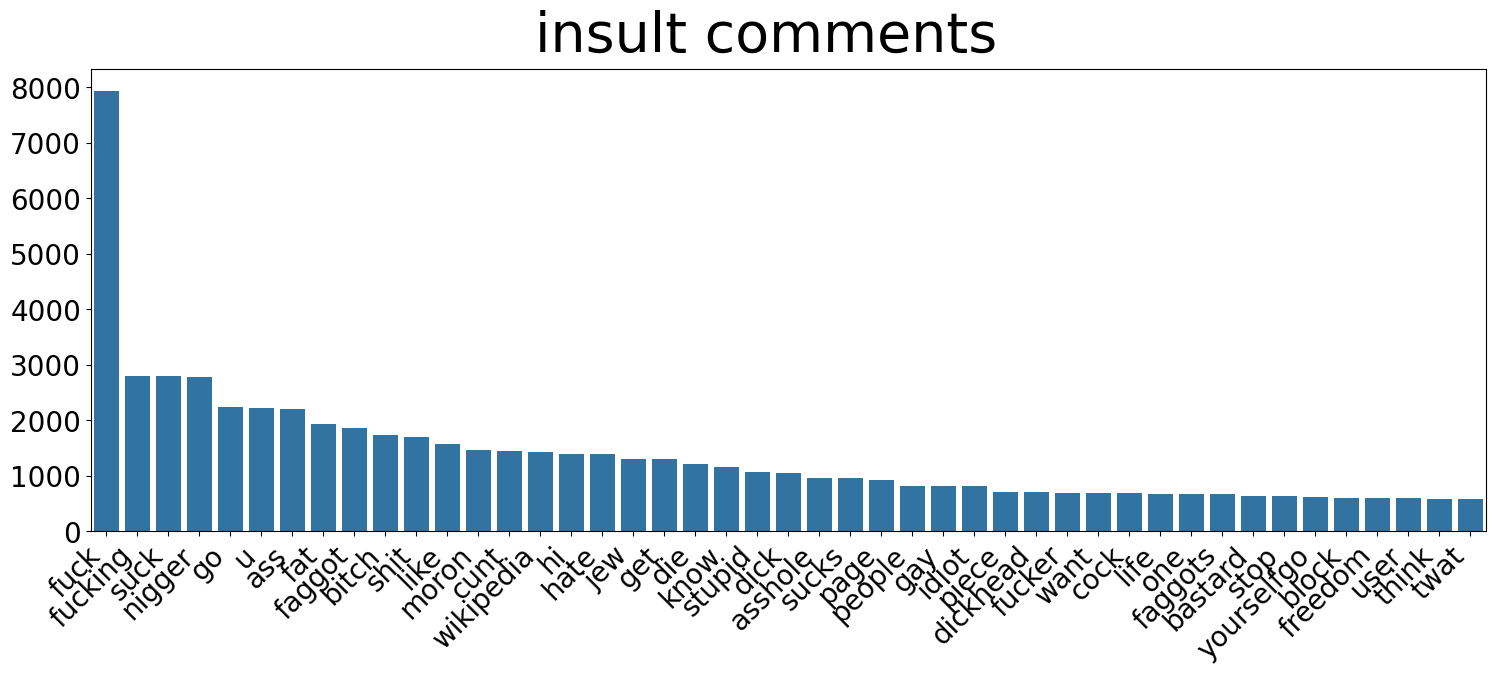

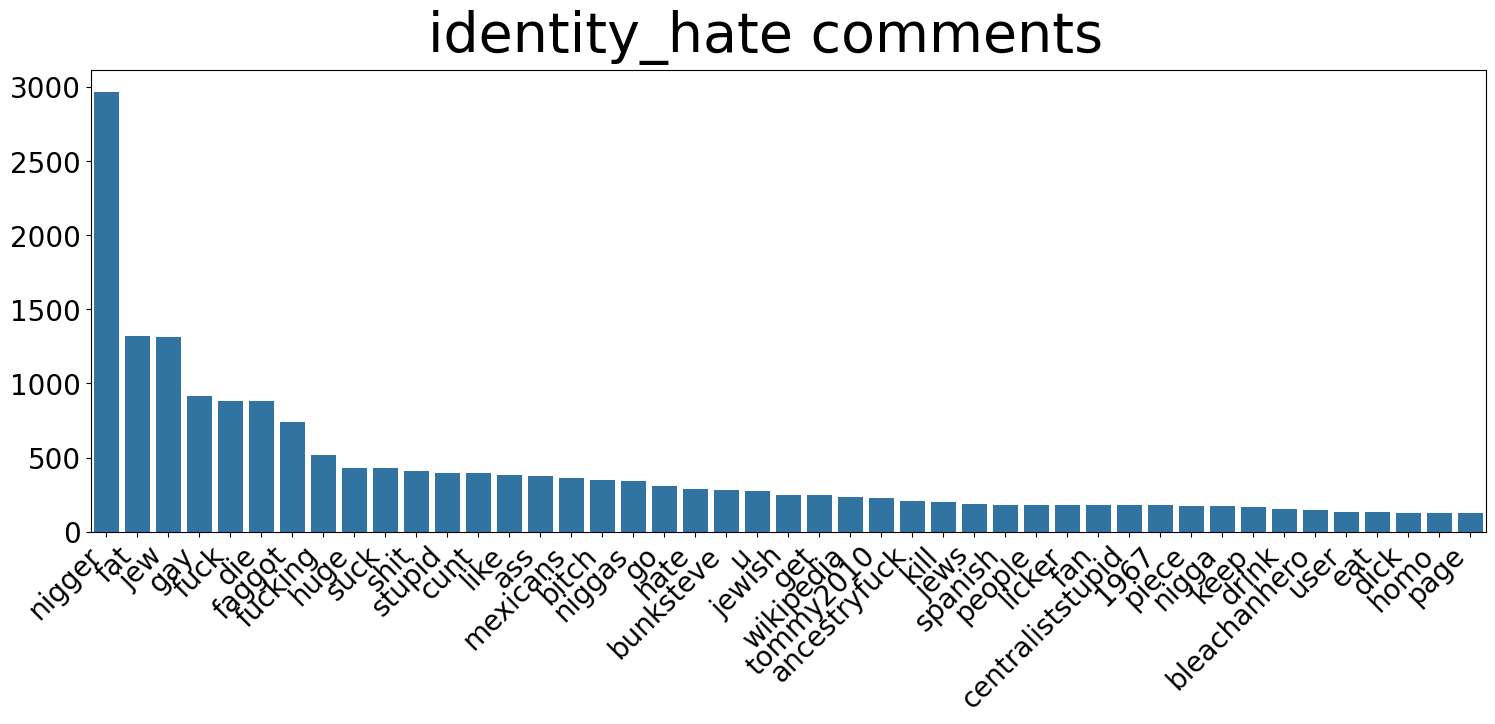

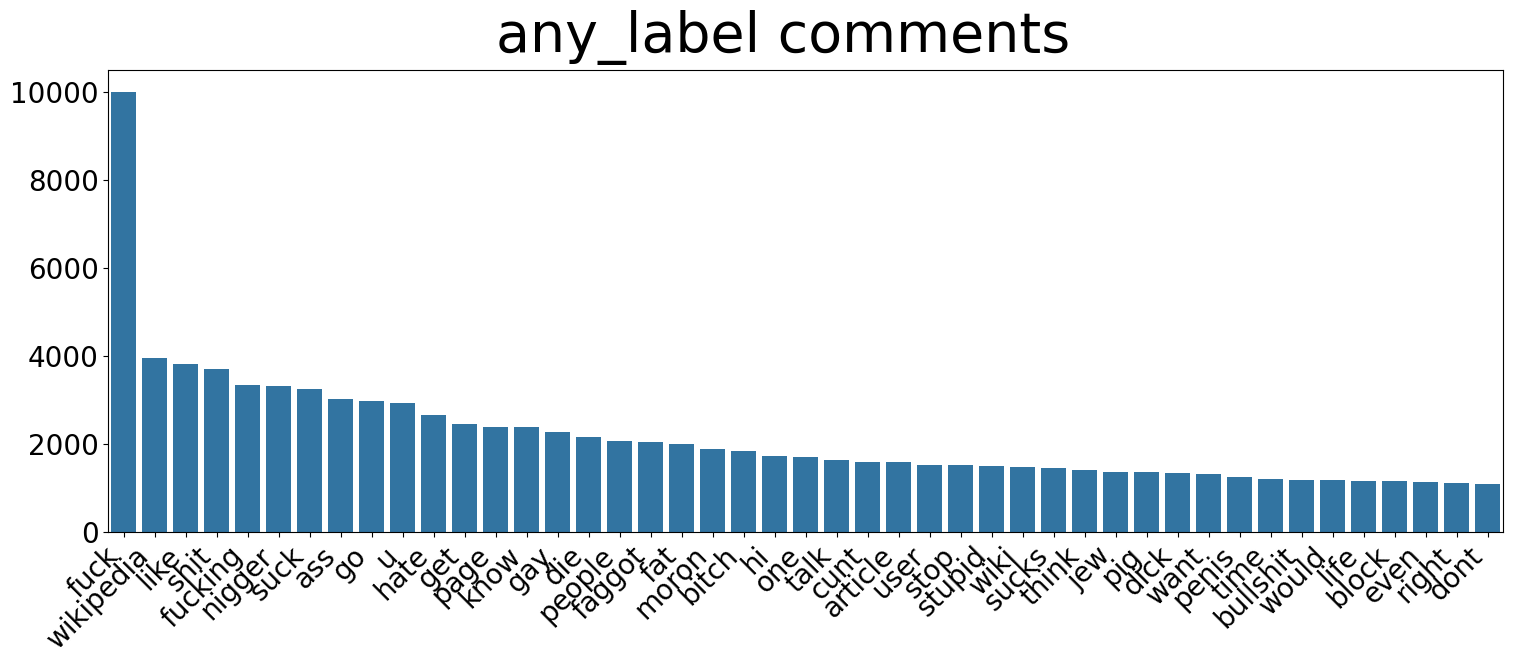

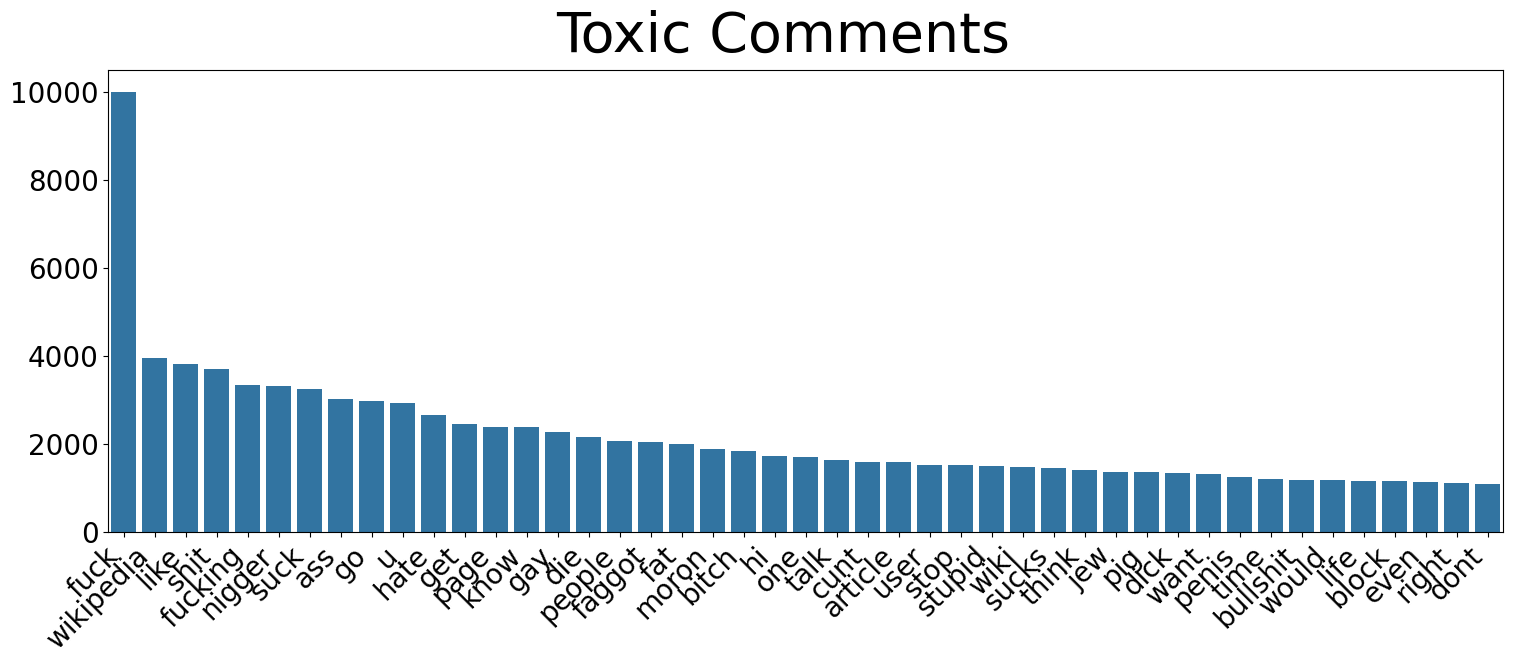

In [27]:
all_tokenizer = Tokenizer(filters = string.punctuation + '\n', lower = True)
all_tokenizer.fit_on_texts(df.comment_text[(toxic_rows==0)])
word_plot(get_word_cnt(all_tokenizer), 45, 'Clean Comments')
print('\n')

for label in targets:
    toxic_tokenizer = Tokenizer(filters = string.punctuation + '\n', lower = True)
    toxic_tokenizer.fit_on_texts(df.comment_text[(toxic_rows==1) & (df_targets[label]==1)])
    word_plot(get_word_cnt(toxic_tokenizer), 45, label + ' comments')
    print('\n')

toxic_tokenizer = Tokenizer(filters = string.punctuation + '\n', lower = True)
toxic_tokenizer.fit_on_texts(df.comment_text[(toxic_rows==1)])
word_plot(get_word_cnt(toxic_tokenizer), 45, 'Toxic Comments')

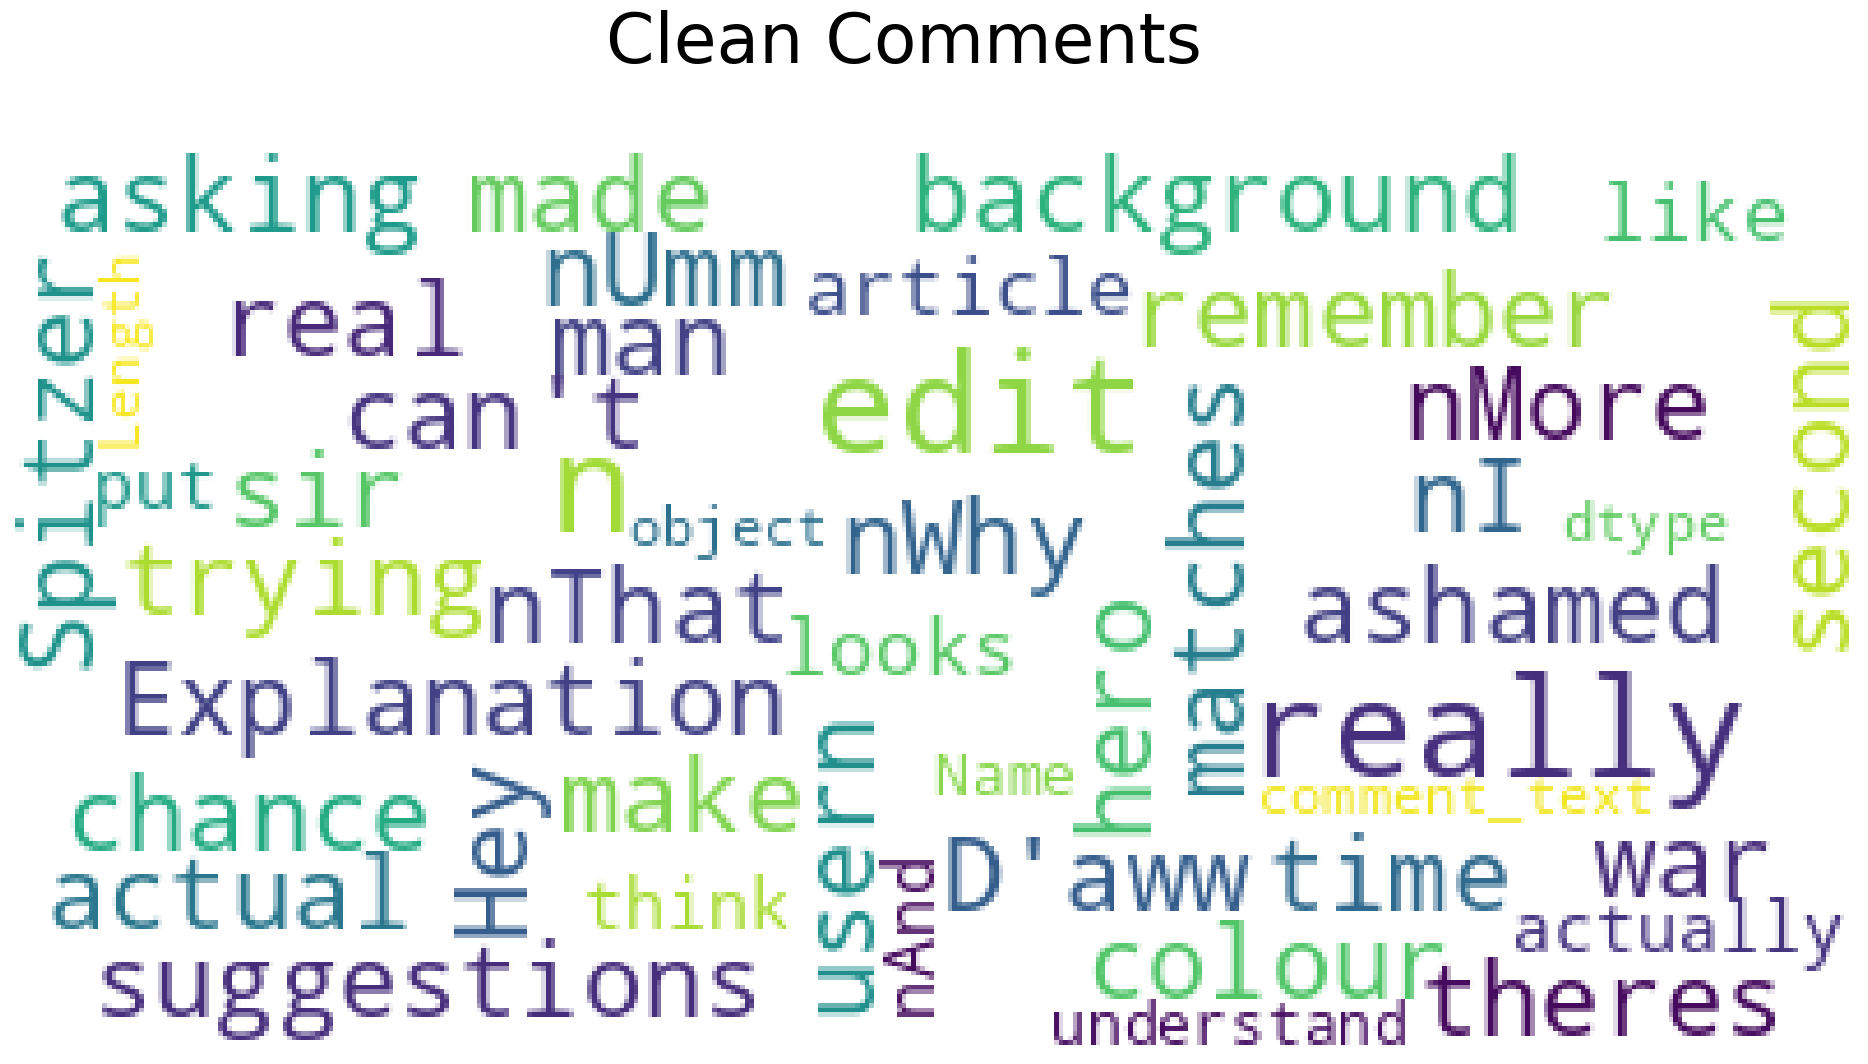

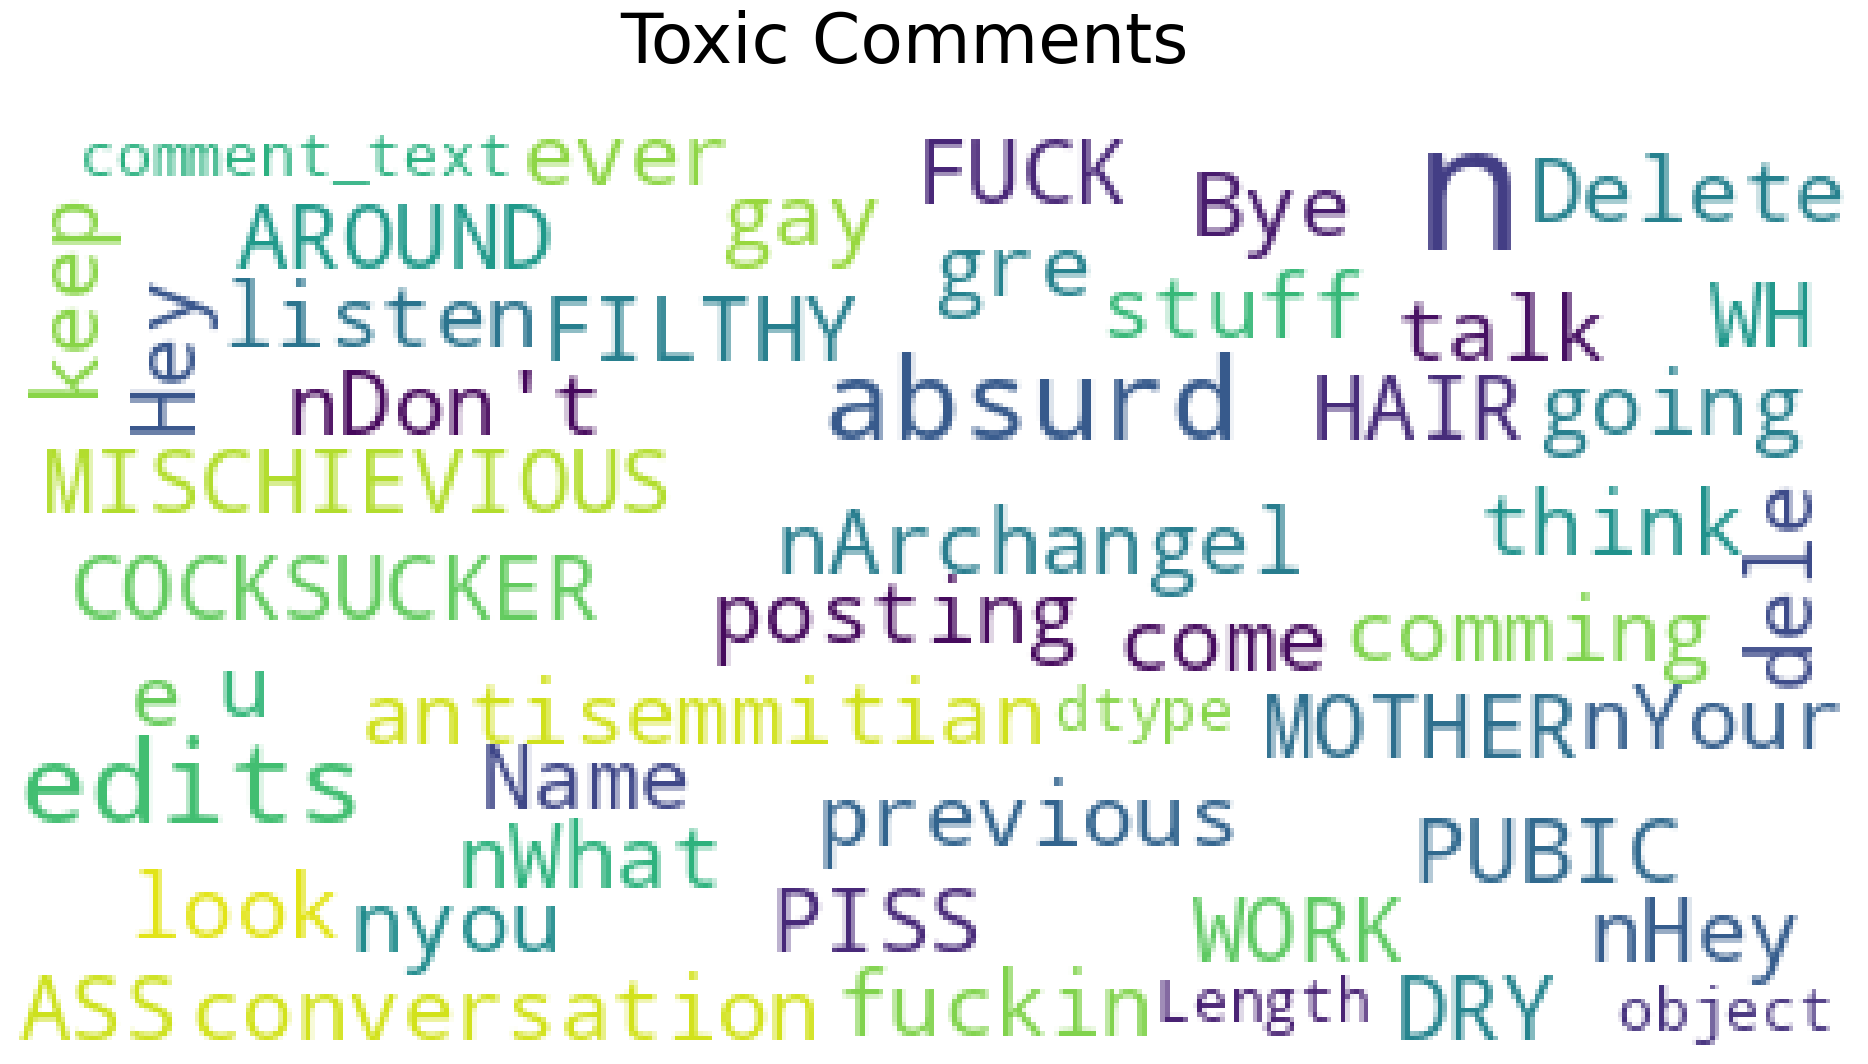

In [28]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color = 'white',
                      stopwords = set(stopwords.words('english')),
                      max_words = 100,
                      max_font_size = 30).generate(str(df.comment_text[(toxic_rows==0)]))

plt.figure('wordcloud', figsize = (24, 12))
plt.suptitle('Clean Comments', fontsize = 50)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
print('\n')

wordcloud = WordCloud(background_color = 'white',
                      stopwords = set(stopwords.words('english')),
                      max_words = 100,
                      max_font_size = 40).generate(str(df.comment_text[(toxic_rows==1)]))
plt.figure('wordcloud', figsize = (24, 12))
plt.suptitle('Toxic Comments', fontsize = 50)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Model Development – TF-IDF + Logistic Regression :

In [43]:
# Import Model Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

In [44]:
# Define Features (X) and Labels (y)
X = df['comment_text']   # input feature
y = df_targets           # target labels

### Train–Test Split :

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

### TF-IDF Vectorization :

In [60]:
tfidf = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    stop_words='english')

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Training Model :

In [61]:
# Sanity check:
# - X_train_tfidf should be a sparse matrix containing TF-IDF features
# - y_train should be a DataFrame/array of target labels (one column per toxic class)
# - Both must have the same number of rows (samples) for model training

print(type(X_train_tfidf))
print(type(y_train))
print(X_train_tfidf.shape)
print(y_train.shape)

<class 'scipy.sparse._csr.csr_matrix'>
<class 'pandas.core.frame.DataFrame'>
(127656, 30000)
(127656, 7)


In [62]:
y_train.dtypes

,0
toxic,int64
severe_toxic,int64
obscene,int64
threat,int64
insult,int64
identity_hate,int64
any_label,int64


In [64]:
model = OneVsRestClassifier(
    LogisticRegression(max_iter=1000))

model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

### Make Predictions :

In [65]:
y_pred = model.predict(X_test_tfidf)
y_prob = model.predict_proba(X_test_tfidf)

In [66]:
print(y_pred.shape)
print(y_prob.shape)

(31915, 7)
(31915, 7)


In [67]:
y_pred[:5]

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

In [68]:
y_prob[:5]

array([[0.10226911, 0.00608615, 0.02942573, 0.00254989, 0.0331953 ,
        0.00838502, 0.13312797],
       [0.00907806, 0.00191779, 0.00321661, 0.00119075, 0.00518025,
        0.00166704, 0.00950558],
       [0.0689605 , 0.00768677, 0.02472429, 0.00257848, 0.03504673,
        0.0082791 , 0.06734845],
       [0.00293384, 0.00174649, 0.00479249, 0.00107625, 0.00354   ,
        0.00142935, 0.00343011],
       [0.01607393, 0.00340538, 0.00794887, 0.00148988, 0.00700853,
        0.00286783, 0.01475673]])

## Model Evaluation :

In [69]:
# Import Evaluation Metrics
from sklearn.metrics import classification_report, f1_score, roc_auc_score

In [70]:
# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=y.columns))

Classification Report:

               precision    recall  f1-score   support

        toxic       0.91      0.60      0.72      3056
 severe_toxic       0.55      0.23      0.32       321
      obscene       0.92      0.61      0.74      1715
       threat       0.67      0.11      0.19        74
       insult       0.82      0.49      0.62      1614
identity_hate       0.72      0.17      0.28       294
    any_label       0.93      0.61      0.74      3244

    micro avg       0.89      0.56      0.69     10318
    macro avg       0.79      0.40      0.51     10318
 weighted avg       0.89      0.56      0.68     10318
  samples avg       0.06      0.05      0.05     10318



In [71]:
# F1 Scores
micro_f1 = f1_score(y_test, y_pred, average='micro')
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Micro F1-score :", micro_f1)
print("Macro F1-score :", macro_f1)

Micro F1-score : 0.6894661582459485
Macro F1-score : 0.5141100178676565


In [72]:
# ROC–AUC Score
roc_auc = roc_auc_score(
    y_test, y_prob, average='micro')

print("Micro-average ROC-AUC :", roc_auc)

Micro-average ROC-AUC : 0.9776849404751544


In [73]:
evaluation_results = {
    "Micro F1": micro_f1,
    "Macro F1": macro_f1,
    "ROC-AUC": roc_auc}

evaluation_results

{'Micro F1': 0.6894661582459485,
 'Macro F1': 0.5141100178676565,
 'ROC-AUC': np.float64(0.9776849404751544)}